In [ ]:
# download data from huggingface
# !wget -c https://huggingface.co/datasets/pscotti/facedataset/resolve/main/sg2_embeds.npy
# !wget -c https://huggingface.co/datasets/pscotti/facedataset/resolve/main/sub-002/betas_1d.npy
# !wget -c https://huggingface.co/datasets/pscotti/facedataset/resolve/main/sub-002/face_ids.npy

In [1]:
import os
import sys
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL

from utils import * 

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
# Load pretrained StyleGAN-XL (https://github.com/autonomousvision/stylegan_xl)
sys.path.append('/scratch/gpfs/KNORMAN/stylegan_ps/')
import dnnlib
import legacy
network_pkl = '/scratch/gpfs/ps6938/stylegan/stylegan2_ada_pytorch/stylegan2-ffhq-config-f.pkl'
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema']
    G = G.eval().requires_grad_(False).to(device)  

Loading networks from "/scratch/gpfs/ps6938/stylegan/stylegan2_ada_pytorch/stylegan2-ffhq-config-f.pkl"...


# Load data

In [2]:
# Load data
sub = '002'

# load flattened voxels with NaNs removed 
voxels = np.load(f'sub-{sub}/betas_1d.npy') 

y = np.load(f'sub-{sub}/face_ids.npy').astype(np.int16)

print(voxels.shape)
print(y.shape)

(1920, 73, 84, 72)
(1920,)


In [4]:
# load sg-2 embeddings per sample
embeds = np.load('sg2_embeds.npy')
embeds = embeds[y]
embeds.shape

(1012, 512)


In [33]:
seed_everything(seed=42)

# if you include different samples of face X in the training and test set, reconstructions look great:
# all_trials = np.random.permutation(np.arange(len(voxels)))
# train_trials = all_trials[all_trials[:1792]]
# val_trials = all_trials[all_trials[1792:]]

# if you ensure that the test set doesn't contain samples of the same face in the training set, reconstructions look bad:
train_trials = np.where(y<=700)[0]
val_trials = np.where(y>700)[0]

train_voxels = torch.Tensor(voxels[train_trials,:])
val_voxels = torch.Tensor(voxels[val_trials,:])
print("Voxels loaded.")

train_embs = torch.Tensor(embeds[train_trials,:])
val_embs = torch.Tensor(embeds[val_trials,:])
print("Embeddings loaded.")

print(train_voxels.shape, train_embs.shape)
print(val_voxels.shape, val_embs.shape)

Voxels loaded.
Embeddings loaded.
torch.Size([1660, 136572]) torch.Size([1660, 512])
torch.Size([260, 136572]) torch.Size([260, 512])


# Reconstruction

In [34]:
assert torch.any(torch.isnan(train_voxels))==False
class BrainNetwork(nn.Module):
    def __init__(self, out_dim, in_dim=voxels.shape[1], h=1028):
        super().__init__()
        self.lin0 = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h),
            nn.Dropout(0.5),
        )
        self.mlp = nn.ModuleList([
            nn.Sequential(
                nn.Linear(h, h),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(h),
                nn.Dropout(0.15)
            ) for _ in range(2)
        ])  
        self.lin1 = nn.Linear(h,out_dim)
    def forward(self, x):
        x = self.lin0(x)
        residual = x
        for res_block in range(2):
            x = self.mlp[res_block](x)
            x += residual
            residual = x
        x = x.reshape(len(x),-1)
        x = self.lin1(x)
        return x
voxels2emb = BrainNetwork(512).to(device)

mse = nn.MSELoss()
initial_learning_rate = 3e-4
optimizer = torch.optim.AdamW(voxels2emb.parameters(), lr=initial_learning_rate)

num_epochs = 60
batch_size = 32

data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(train_voxels,#[torch.randperm(len(train_voxels))], 
                                                                                 train_embs),
                                                                    batch_size=batch_size, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(val_voxels, 
                                                                                 val_embs),
                                                                    batch_size=batch_size, shuffle=False)

train_losses = []; val_losses = []; lrs = [];
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    voxels2emb.train()
    epoch_loss = 0
    for train_i, (voxel, emb) in enumerate(data_loader):
        voxel = voxel.to(device)
        emb = emb.to(device)
        
        optimizer.zero_grad(set_to_none=True) # reset gradients
        
        emb_ = voxels2emb(voxel)
        
        loss = mse(emb,emb_) 

        loss.backward() # backpropagate
        optimizer.step() # gradient descent
        
        epoch_loss += loss.item()
        
        lrs.append(optimizer.param_groups[0]['lr'])
        
    train_losses.append(epoch_loss/(train_i+1))
        
    voxels2emb.eval()
    epoch_val_loss = 0
    for val_i, (val_voxel, val_emb) in enumerate(data_loader_val):
        val_voxel = val_voxel.to(device)
        val_emb = val_emb.to(device)
        
        with torch.no_grad():
            val_emb_ = voxels2emb(val_voxel)
        
        val_loss = mse(val_emb,val_emb_)
        epoch_val_loss += val_loss.item()
        
    val_losses.append(epoch_val_loss/(val_i+1))
        
    pbar.set_description(f"Train Loss: {np.mean(train_losses[-1]):.3f} | Val Loss: {np.mean(val_losses[-1]):.3f}")
print("DONE!")

Train Loss: 0.015 | Val Loss: 0.224: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.60it/s]

DONE!


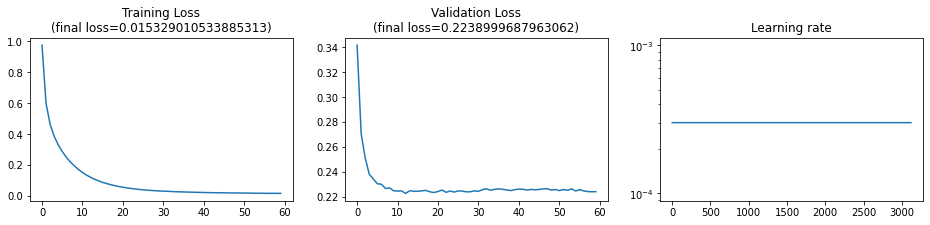

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,3))
ax1.set_title(f"Training Loss\n(final loss={train_losses[-1]})")
ax1.plot(train_losses)
ax2.set_title(f"Validation Loss\n(final loss={val_losses[-1]})")
ax2.plot(val_losses)
ax3.set_title("Learning rate")
ax3.plot(lrs)
ax3.set_yscale('log')
plt.show()

Train Loss: 0.015 | Val Loss: 0.224
TRAINING


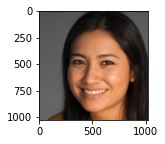

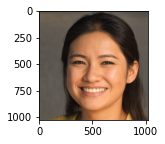

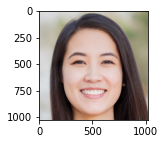

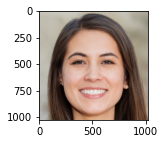

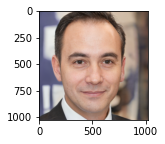

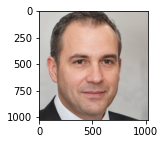

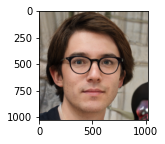

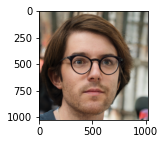


VALIDATION


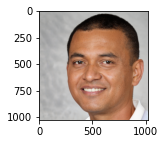

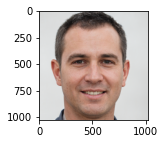

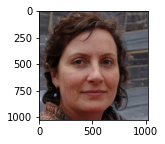

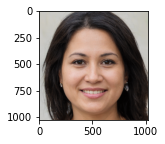

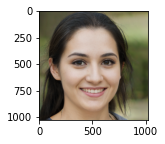

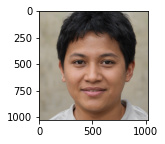

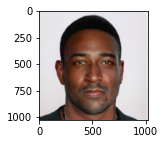

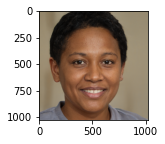

In [36]:
print(f"Train Loss: {np.mean(train_losses[-1]):.3f} | Val Loss: {np.mean(val_losses[-1]):.3f}")
print('TRAINING')
bs=6 if len(val_emb)>4 else len(val_emb)
for i in range(bs):
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(emb[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(emb_[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()

print('\nVALIDATION')

for i in range(bs):
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(val_emb[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()
    plt.figure(figsize=(2,2))
    z = torch.Tensor.repeat(val_emb_[i],(18,1)).to(device)[None]
    pic_ = G.synthesis(z, noise_mode='const')
    plt.imshow(torch_to_matplotlib(pic_))
    plt.grid(False)
    plt.show()